In [1]:
import opendatasets as od
import pandas as pd
import random
import numpy as np
import math
import fastparquet 
import pyarrow

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

1. Download the Dataset

In [2]:
dataset_url = 'https://www.kaggle.com/c/new-york-city-taxi-fare-prediction'

In [3]:
od.download(dataset_url)

Skipping, found downloaded files in "./new-york-city-taxi-fare-prediction" (use force=True to force download)


In [4]:
data_dir = 'new-york-city-taxi-fare-prediction'

In [5]:
!ls -lh {data_dir}

total 5.4G
-rw-rw-r-- 1 kurios kurios  486 Jun  5 18:16 GCP-Coupons-Instructions.rtf
-rw-rw-r-- 1 kurios kurios 336K Jun  5 18:16 sample_submission.csv
-rw-rw-r-- 1 kurios kurios 960K Jun  5 18:16 test.csv
-rw-rw-r-- 1 kurios kurios 5.4G Jun  5 18:17 train.csv


In [6]:
!wc -l {data_dir}/train.csv

55423856 new-york-city-taxi-fare-prediction/train.csv


In [7]:
!wc -l {data_dir}/test.csv

9914 new-york-city-taxi-fare-prediction/test.csv


In [8]:
!wc -l {data_dir}/sample_submission.csv

9915 new-york-city-taxi-fare-prediction/sample_submission.csv


In [9]:
!head {data_dir}/train.csv

key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.84161,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.76127,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.98713,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.73163,-73.972892,40.758233,1
2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.9513,40.774138,-73.990095,40.751048,1
2012-12-03 13:10:00.000000125,9,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.99

In [10]:
!head {data_dir}/test.csv

key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320007324219,40.7638053894043,-73.981430053710938,40.74383544921875,1
2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862182617188,40.719383239746094,-73.998886108398438,40.739200592041016,1
2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.75126,-73.979654,40.746139,1
2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.98116,40.767807,-73.990448,40.751635,1
2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
2012-12-01 21:12:12.0000005,2012-12-01 21:12:12 UTC,-73.960983,40.765547,-73.979177,40.740053,1
2011-10-06 12:10:20.0000001,2011-10-06 12:10:20 UTC,-73.949013,40.773204,-73.959622,40.770893,1
2011-10-06 12:10:20.0000003,2011-10-06 12:10:20 UTC,-73.777282,40.646636,-73.985083,40.759368,1
2011-10-06 12:10:20.0000002,2011-10-06 12:10:20 UTC,-74.01409

In [11]:
!head {data_dir}/sample_submission.csv

key,fare_amount
2015-01-27 13:08:24.0000002,11.35
2015-01-27 13:08:24.0000003,11.35
2011-10-08 11:53:44.0000002,11.35
2012-12-01 21:12:12.0000002,11.35
2012-12-01 21:12:12.0000003,11.35
2012-12-01 21:12:12.0000005,11.35
2011-10-06 12:10:20.0000001,11.35
2011-10-06 12:10:20.0000003,11.35
2011-10-06 12:10:20.0000002,11.35


In [12]:
sample_fraction = 0.01

In [13]:
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')

dtypes = {
    'fare_amount,' : 'float32',
    'pickup_longitude' : 'float32',
    'pickup_latitude' : 'float32',
    'dropoff_longitude' : 'float32',
    'dropoff_latitude' : 'float32',
    'passenger_count' : 'uint8'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_fraction

random.seed(42)

In [14]:
df = pd.read_csv(data_dir+'/train.csv',
            usecols = selected_cols,
            parse_dates=['pickup_datetime'],
            dtype=dtypes,
            skiprows=skip_row)

In [15]:
test_df = pd.read_csv(data_dir+'/test.csv', parse_dates=['pickup_datetime'], dtype=dtypes)
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


2. Explore the Dataset

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float64            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float32            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(4), float64(1), uint8(1)
memory usage: 17.4 MB


In [17]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934265,1.684983
std,9.811924,11.618246,8.061114,12.074346,9.255058,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150635,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733990,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753101,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768059,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403076,208.000000


In [18]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(4), object(1), uint8(1)
memory usage: 319.6+ KB


In [20]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568974,1.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000


In [21]:
test_df['pickup_datetime'].min(), test_df['pickup_datetime'].max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

In [22]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [23]:
len(train_df), len(val_df)

(441960, 110490)

3. Prepare Dataset for Training

In [24]:
train_df = train_df.dropna()
val_df = val_df.dropna()

In [25]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [26]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
target_col = 'fare_amount'

In [27]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [28]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [29]:
test_inputs = test_df[input_cols]
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


4. Train Hardcoded & Baseline Models

In [30]:
class MeanRegressor:
    def fit(self, inputs, targets):
        self.mean = targets.mean()
    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

In [31]:
mean_model = MeanRegressor()
mean_model.fit(train_inputs, train_targets)
mean_model.mean

np.float64(11.354714227531904)

In [32]:
train_preds = mean_model.predict(train_inputs)
val_preds = mean_model.predict(val_inputs)

In [33]:
def rmse(targets, preds):
    return root_mean_squared_error(targets, preds)

In [34]:
train_rmse = rmse(train_targets, train_preds)
train_rmse

9.789781929882418

In [35]:
linear_model = LinearRegression().fit(X=train_inputs, y=train_targets)
train_preds=linear_model.predict(train_inputs)
train_preds

array([11.546237, 11.28461 , 11.28414 , ..., 11.458918, 11.284281,
       11.284448], shape=(441960,), dtype=float32)

In [36]:
rmse(train_preds, train_targets)

9.788632606440878

In [37]:
val_preds = linear_model.predict(val_inputs)
rmse(val_preds, val_targets)

9.898088157709763

In [38]:
test_preds = linear_model.predict(test_inputs)
submission_df = pd.read_csv(data_dir+'/sample_submission.csv')

In [39]:
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [40]:
test_preds

array([11.28428  , 11.284634 , 11.284384 , ..., 11.721249 , 11.7207985,
       11.720594 ], shape=(9914,), dtype=float32)

In [41]:
submission_df['fare_amount'] = test_preds
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.284280
1,2015-01-27 13:08:24.0000003,11.284634
2,2011-10-08 11:53:44.0000002,11.284384
3,2012-12-01 21:12:12.0000002,11.284222
4,2012-12-01 21:12:12.0000003,11.284050
...,...,...
9909,2015-05-10 12:37:51.0000002,11.720277
9910,2015-01-12 17:05:51.0000001,11.720225
9911,2015-04-19 20:44:15.0000001,11.721249
9912,2015-01-31 01:05:19.0000005,11.720798


5. Make Predictions and Submit to Kaggle

In [42]:
def predict_and_submit(model, test_inputs, fname):
    test_preds = model.predict(test_inputs)
    submission_df = pd.read_csv(data_dir+'/sample_submission.csv')
    submission_df['fare_amount'] = test_preds
    submission_df.to_csv(fname, index=None)
    return submission_df


In [43]:
predict_and_submit(linear_model, test_inputs, 'linear_model_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.284280
1,2015-01-27 13:08:24.0000003,11.284634
2,2011-10-08 11:53:44.0000002,11.284384
3,2012-12-01 21:12:12.0000002,11.284222
4,2012-12-01 21:12:12.0000003,11.284050
...,...,...
9909,2015-05-10 12:37:51.0000002,11.720277
9910,2015-01-12 17:05:51.0000001,11.720225
9911,2015-04-19 20:44:15.0000001,11.721249
9912,2015-01-31 01:05:19.0000005,11.720798


6. Feature Engineering

In [44]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [45]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [46]:
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [47]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [48]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

In [49]:
def add_landmarks(df):
    landmarks = [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]
    for name, lonlat in landmarks:
        add_landmark_dropoff_distance(df, name, lonlat)

In [50]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [51]:
add_dateparts(train_df, 'pickup_datetime')
add_dateparts(val_df, 'pickup_datetime')
add_dateparts(test_df, 'pickup_datetime')

In [52]:
add_trip_distance(train_df)
add_trip_distance(val_df)
add_trip_distance(test_df)

In [53]:
add_landmarks(train_df)
add_landmarks(val_df)
add_landmarks(test_df)

In [54]:
train_df = remove_outliers(train_df)
val_df = remove_outliers(val_df)

In [55]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000,431098.000000
mean,11.347895,-73.975121,40.750957,-73.974342,40.751324,1.690374,2011.737524,6.266821,15.732629,3.035066,13.506704,3.330515,20.913206,9.693021,18.474831,4.497471,5.967942
std,9.714552,0.039226,0.030028,0.038444,0.033221,1.306414,1.862116,3.436091,8.697833,1.950459,6.516894,3.741833,3.105583,3.091470,3.759176,3.804997,3.995043
min,1.000000,-74.839172,40.063896,-74.843079,40.054207,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305583,0.116402,0.129245,0.031195,0.009281
25%,6.000000,-73.992249,40.736530,-73.991592,40.735497,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.253382,20.519000,8.323345,16.477411,2.140186,3.585761
50%,8.500000,-73.982101,40.753319,-73.980606,40.753765,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.153255,21.173625,9.520789,17.958796,3.720862,5.488690
75%,12.500000,-73.968399,40.767437,-73.965401,40.768360,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.917217,21.898378,10.986174,19.785087,5.906888,7.641019
max,400.000000,-72.982796,41.787712,-72.935562,41.806301,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,113.474625,130.364136,114.624855,125.375267,114.114685,121.605186


In [56]:
train_df.to_parquet('train.parquet')
val_df.to_parquet('val.parquet')
test_df.to_parquet('test.parquet')

In [57]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [58]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

In [59]:
target_col = 'fare_amount'

In [60]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]
test_inputs = test_df[input_cols]

In [61]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = root_mean_squared_error(train_targets, train_preds)
    val_preds = model.predict(val_inputs)
    val_rmse = root_mean_squared_error(val_targets, val_preds)
    return train_rmse, val_rmse, train_preds, val_preds

In [62]:
ridge_model = Ridge(random_state=42, alpha=.9)
ridge_model.fit(train_inputs, train_targets)

Ridge(alpha=0.9, random_state=42)

In [63]:
evaluate(ridge_model)

(5.049313999521027,
 5.217845576716579,
 array([ 8.12923645,  4.11617245,  8.75016004, ..., 10.47209137,
         8.2307147 , 10.58695526], shape=(431098,)),
 array([10.91913863,  6.20507269, 46.21884766, ...,  8.04612767,
        25.56777303,  8.45283359], shape=(107742,)))

In [64]:
predict_and_submit(ridge_model, test_inputs, 'ridge_submission2.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.081975
1,2015-01-27 13:08:24.0000003,11.400098
2,2011-10-08 11:53:44.0000002,5.356945
3,2012-12-01 21:12:12.0000002,8.763523
4,2012-12-01 21:12:12.0000003,14.609347
...,...,...
9909,2015-05-10 12:37:51.0000002,9.024146
9910,2015-01-12 17:05:51.0000001,11.217690
9911,2015-04-19 20:44:15.0000001,47.927670
9912,2015-01-31 01:05:19.0000005,22.600263


In [65]:
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=10, n_estimators=200)

In [66]:
random_forest_model.fit(train_inputs, train_targets)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [67]:
evaluate(random_forest_model)

(3.5937762428320474,
 4.158518338375154,
 array([ 6.96083317,  9.10333872,  9.1439826 , ..., 10.42571766,
         7.77727488, 10.42170813], shape=(431098,)),
 array([12.62018499,  6.14559021, 47.30322959, ...,  8.36950355,
        29.19683335,  8.25005043], shape=(107742,)))

In [68]:
predict_and_submit(random_forest_model, test_inputs, 'random_forest_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.474756
1,2015-01-27 13:08:24.0000003,10.469208
2,2011-10-08 11:53:44.0000002,5.040013
3,2012-12-01 21:12:12.0000002,8.534310
4,2012-12-01 21:12:12.0000003,14.284250
...,...,...
9909,2015-05-10 12:37:51.0000002,8.756386
9910,2015-01-12 17:05:51.0000001,12.506813
9911,2015-04-19 20:44:15.0000001,55.403650
9912,2015-01-31 01:05:19.0000005,21.513880


In [69]:
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror', n_estimators=100, max_depht=5)

In [70]:
xgb_model.fit(train_inputs, train_targets)

/home/kurios/Documents/ML/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:56:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "max_depht" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depht=5,
             max_depth=None, max_leaves=None, min_child_weight=None,
             missing=nan, monotone_constraints=None, multi_strategy=None,
             n_estimators=100, n_jobs=-1, ...)

In [71]:
evaluate(xgb_model)

(3.1664279772517685,
 3.979379927569826,
 array([ 6.653713 ,  8.931815 , 10.276588 , ..., 12.1582575,  9.564414 ,
         9.845059 ], shape=(431098,), dtype=float32),
 array([14.876896 ,  5.986584 , 47.171738 , ...,  7.5201406, 30.39466  ,
         8.515031 ], shape=(107742,), dtype=float32))

In [72]:
predict_and_submit(xgb_model, test_inputs, 'xgb_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.819051
1,2015-01-27 13:08:24.0000003,11.724770
2,2011-10-08 11:53:44.0000002,4.443203
3,2012-12-01 21:12:12.0000002,9.096115
4,2012-12-01 21:12:12.0000003,16.050816
...,...,...
9909,2015-05-10 12:37:51.0000002,9.119739
9910,2015-01-12 17:05:51.0000001,11.764132
9911,2015-04-19 20:44:15.0000001,53.424809
9912,2015-01-31 01:05:19.0000005,18.867956


8. Tune Hyperparmeters

In [73]:
def test_params(ModelClass, **params):
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = root_mean_squared_error(model.predict(train_inputs), train_targets)
    val_rmse = root_mean_squared_error(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [74]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror',
}

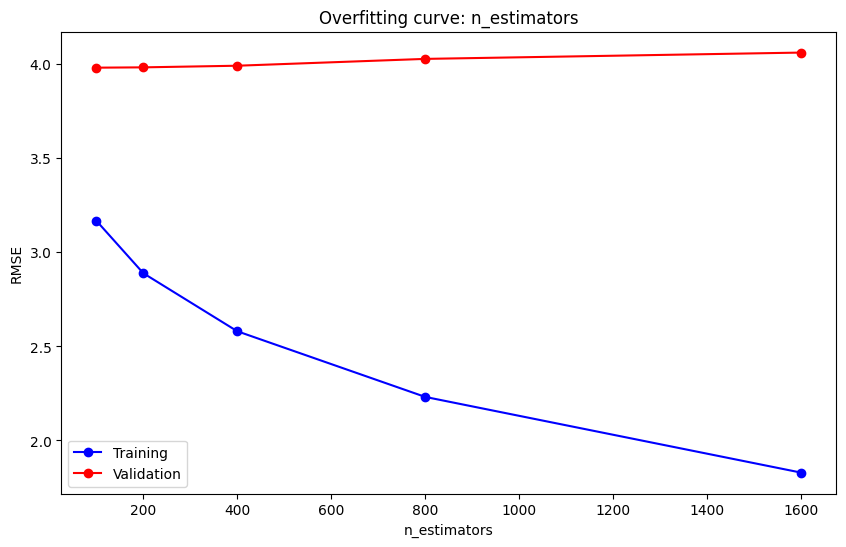

In [75]:
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 200, 400, 800,  1600], **best_params)

In [90]:
best_params['n_estimators'] = 1600

In [ ]:
test_param_and_plot(XGBRegressor, 'max_depth', [5, 6, 7, 8, 9], **best_params)

In [78]:
best_params['max_depth'] = 6

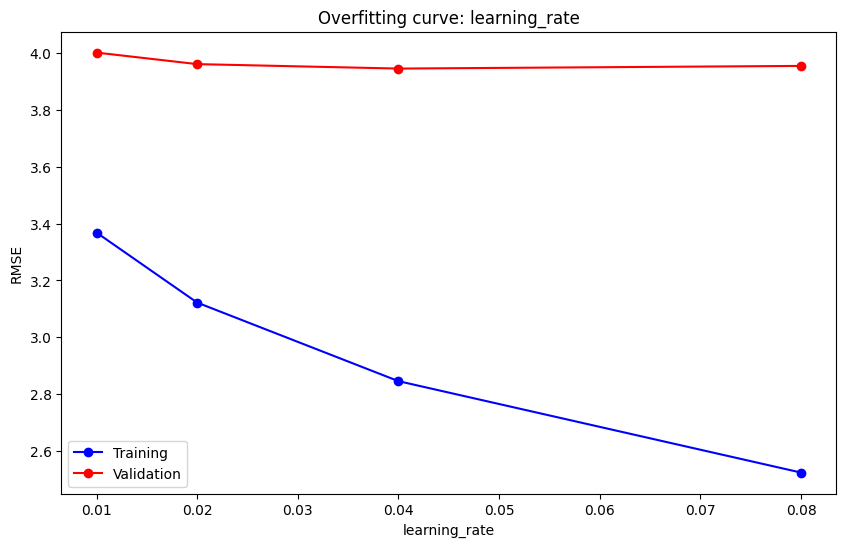

In [91]:
test_param_and_plot(XGBRegressor, 'learning_rate', [0.01, 0.02, 0.04, 0.08], **best_params)

In [ ]:
best_params['learning_rate'] = 0.04

In [ ]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=2000, max_depth=6, learning_rate=0.04, 
                               subsample=0.8, colsample_bytree=0.8)

In [93]:
xgb_model_final.fit(train_inputs, train_targets)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=2000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [94]:
evaluate(xgb_model_final)

(2.7196834066484983,
 3.963903696942249,
 array([ 6.6497746,  7.7816143,  9.8232155, ..., 12.10933  ,  9.464694 ,
         9.918934 ], shape=(431098,), dtype=float32),
 array([15.3561125,  5.7000623, 47.79419  , ...,  7.9298286, 31.10553  ,
         8.47793  ], shape=(107742,), dtype=float32))

In [89]:
predict_and_submit(xgb_model_final, test_inputs, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.978162
1,2015-01-27 13:08:24.0000003,11.239701
2,2011-10-08 11:53:44.0000002,4.305638
3,2012-12-01 21:12:12.0000002,8.679687
4,2012-12-01 21:12:12.0000003,16.410177
...,...,...
9909,2015-05-10 12:37:51.0000002,9.000618
9910,2015-01-12 17:05:51.0000001,10.759208
9911,2015-04-19 20:44:15.0000001,54.923122
9912,2015-01-31 01:05:19.0000005,19.379587
